In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from helper_func import *
from PIL import Image
import PIL.ImageOps
#from skimage.restoration import unwrap_phase

## hologram generation

In [2]:
M = 1024; #rendered window y resolution
N = 1024; #rendered window x resolution
Dm = 0.008; #SLM y pixel pitch = hologram pixel pitch (except for fresnel propagation)
Dn = 0.008; #SLM x pixel pitch = hologram pixel pitch (except for fresnel propagation)

In [3]:
lamb = 0.000638; #wave length
offset = 0.75*2*pi; #4F amplitude modulation setup phase offset
z = 100 #propagation distance

In [4]:
#display cube
nSlices = 5; #number of image planes
zSlices = np.linspace(z,z-50,nSlices); #position of image planes

dCube = 300; edgeWidth = 10;
fb_offset = 100;
U = np.zeros((M,N,nSlices),dtype=np.complex);

y0Front = round(M/2 - dCube/2 + fb_offset/2);
x0Front = round(N/2 - dCube/2 - fb_offset/2);
x1Front = x0Front + dCube;
y1Front = y0Front + dCube;
x0Back = x0Front + fb_offset;
y0Back = y0Front - fb_offset;
x1Back = x0Back + dCube;
y1Back = y0Back + dCube;

#Vorderseite
U[y0Front:y1Front,x0Front:x0Front+edgeWidth,0] = 1;
U[y0Front:y1Front,x1Front:x1Front+edgeWidth,0] = 1;
U[y0Front:y0Front+edgeWidth,x0Front:x1Front,0] = 1;
U[y1Front:y1Front+edgeWidth,x0Front:x1Front,0] = 1;

#Hinterseite
U[y0Back:y1Back,x0Back:x0Back+edgeWidth,-1] = 1;
U[y0Back:y1Back,x1Back:x1Back+edgeWidth,-1] = 1;
U[y0Back:y0Back+edgeWidth,x0Back:x1Back,-1] = 1;
U[y1Back:y1Back+edgeWidth,x0Back:x1Back,-1] = 1;

#Kanten in z-Richtung
iSlice = 1;
counter = 0;
for pos in range(fb_offset):
    if (counter*(nSlices-2)/fb_offset) > 1:
        iSlice = iSlice +1;
        counter = 0;

    U[(y0Front-pos):(y0Front-pos+edgeWidth),(x0Front+pos):(x0Front+pos+edgeWidth),iSlice] = 1;
    U[(y1Front-pos):(y1Front-pos+edgeWidth),(x0Front+pos):(x0Front+pos+edgeWidth),iSlice] = 1;
    U[(y0Front-pos):(y0Front-pos+edgeWidth),(x1Front+pos):(x1Front+pos+edgeWidth),iSlice] = 1;
    U[(y1Front-pos):(y1Front-pos+edgeWidth),(x1Front+pos):(x1Front+pos+edgeWidth),iSlice] = 1;

    counter = counter+1;

In [5]:
print('depth-slices:',zSlices)

depth-slices: [100.   87.5  75.   62.5  50. ]


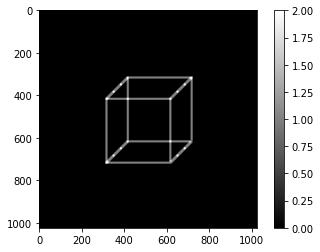

In [6]:
#display object
combi = np.zeros((M,N))
for ii in range(nSlices):
    combi += np.abs( U[:,:,ii] )
    #plt.imshow(U[:,:,ii],cmap='gray')
    #plt.show()
plt.imshow(combi,cmap='gray')
plt.colorbar()
plt.show()

In [7]:
#add random phase
U *= np.exp(i*2*pi*np.random.rand(M,N,nSlices))

In [8]:
#wavefield propagation to SLM
E = np.zeros((M,N),dtype=np.complex);
for ii in range(nSlices):
    z = zSlices[ii]
    E += angular_spectrum(U[:,:,ii],-z,N,M,Dn,Dm,lamb)
    #E += plane_wave(U[:,:,ii],-z,N,M,Dn,Dm,lamb)
E[np.argwhere(np.isnan(E))] = 0
E = E/np.max(np.abs(E))

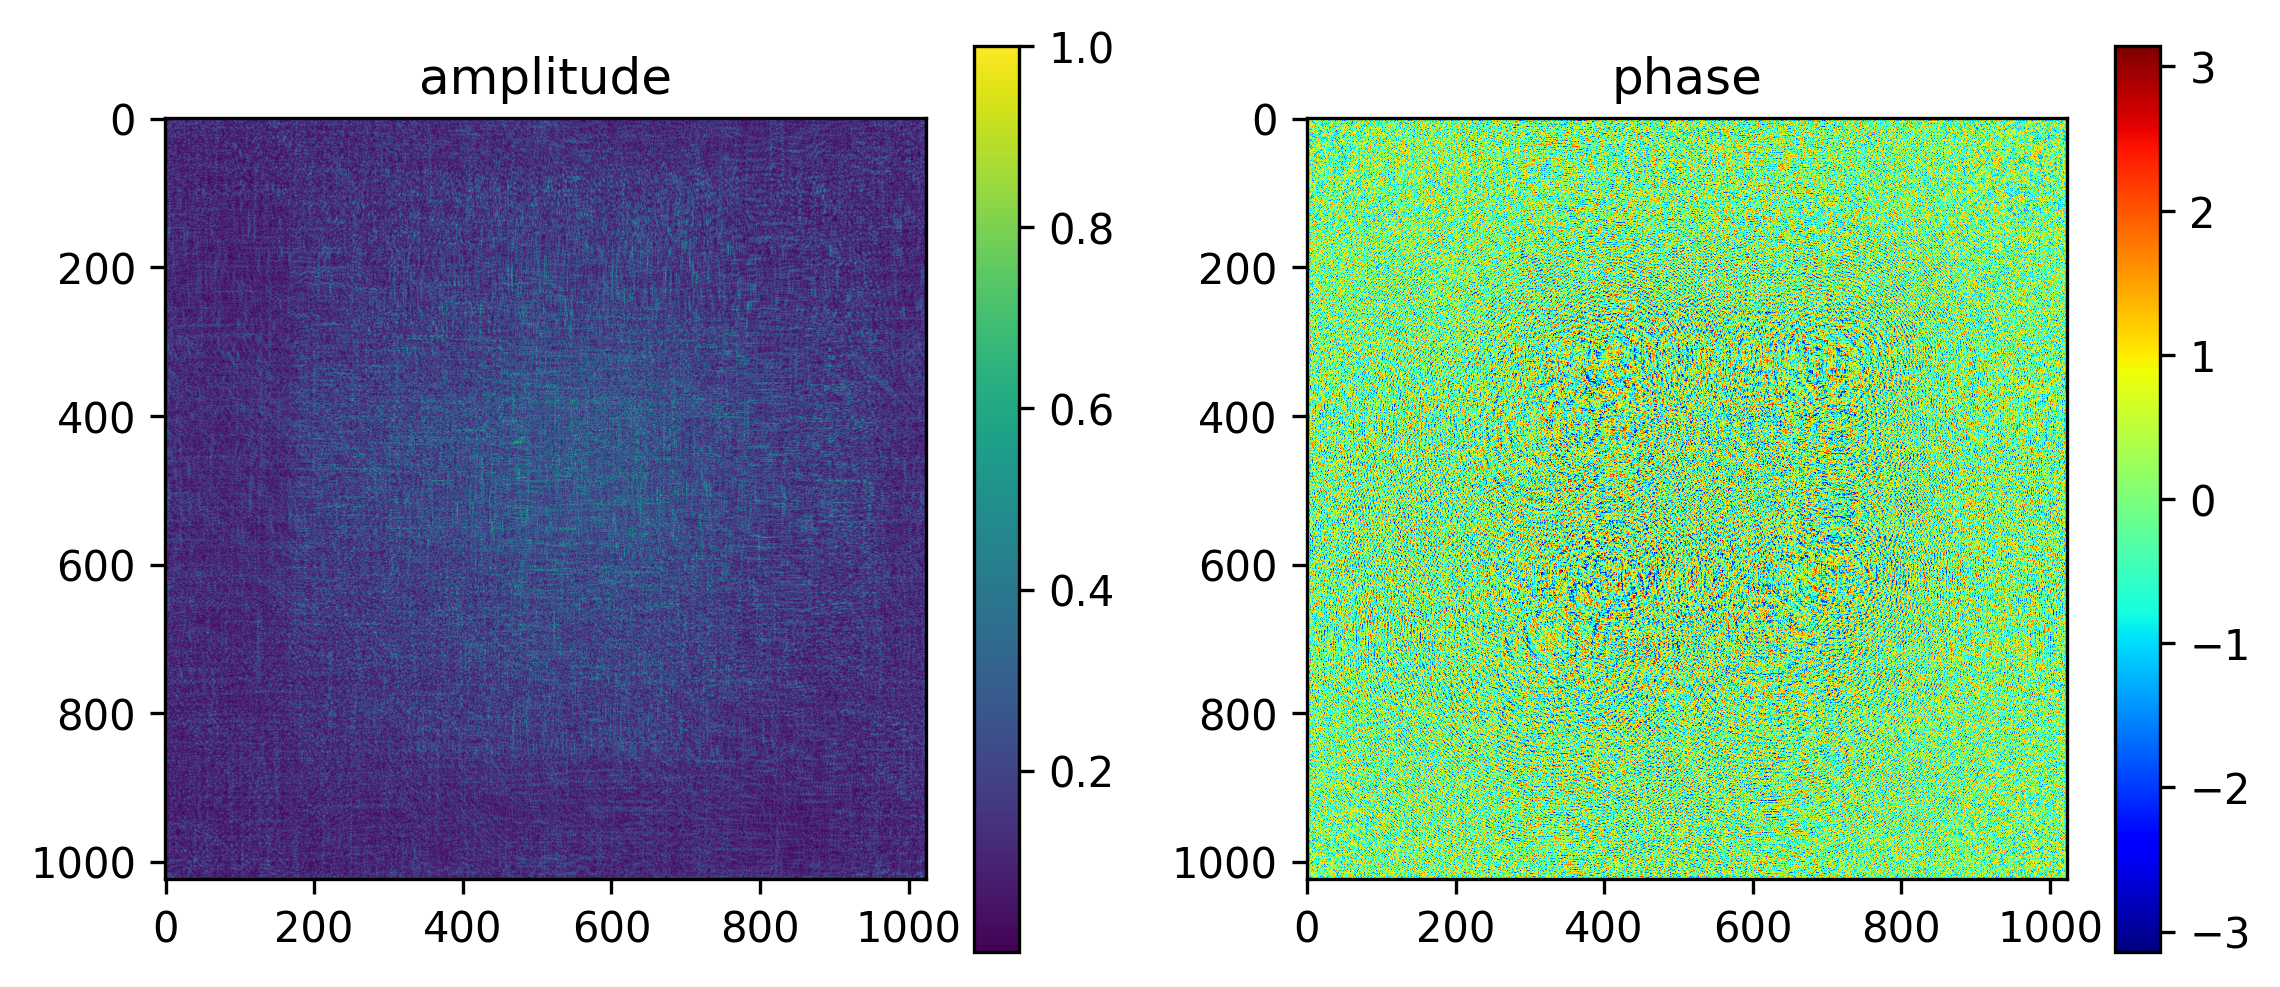

In [9]:
plt.figure(figsize=(9,4),dpi=300)
plt.subplot(1,2,1)
plt.title('amplitude')
plt.imshow(np.abs(E))
plt.colorbar()
plt.subplot(1,2,2)
plt.title('phase')
plt.imshow(np.angle(E),cmap='jet')
plt.colorbar()
plt.show()

In [10]:
#save
np.save('./wavefield',E)

## hologram reconstruction

In [11]:
#load
E = np.load('./wavefield.npy')
#E = np.load('./wavefield_modified.npy')

In [12]:
#observe hologramm from distance z
Ez = angular_spectrum(E,z,N,M,Dn,Dm,lamb)
#Ez = plane_wave(E,z,N,M,Dn,Dm,lamb)

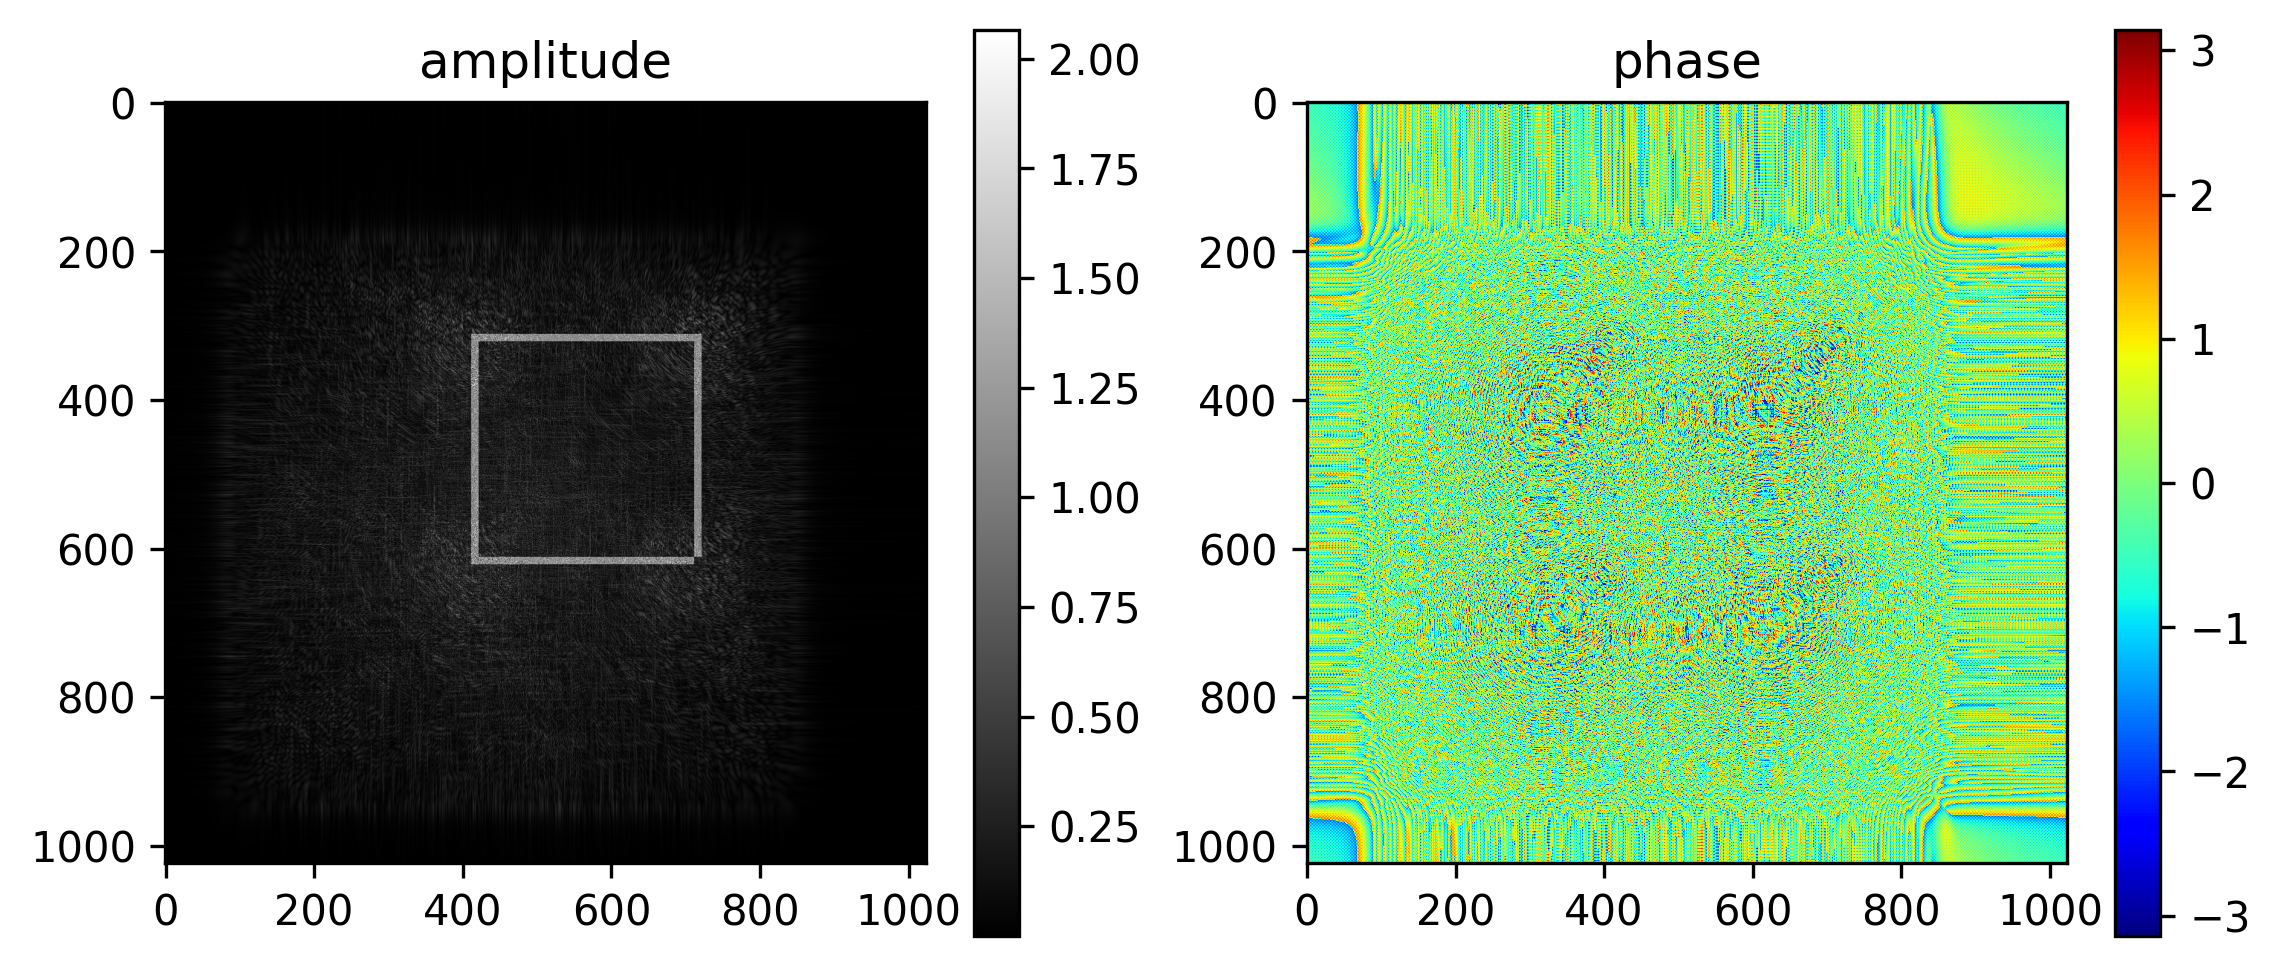

In [13]:
plt.figure(figsize=(9,4),dpi=300)
plt.subplot(1,2,1)
plt.title('amplitude')
plt.imshow(np.abs(Ez),cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.title('phase')
plt.imshow(np.angle(Ez),cmap='jet')
plt.colorbar()
plt.show()

## phase encoding

In [14]:
#for RELPH (michelson interferometer with two slms instead of mirrors)
phi1,phi2 = phasesRELPH(E)
savePhase(phi1,phi2,0,lamb,'RELPH.png');

In [15]:
#for 4f setup with slm1 for phase modulation and slm2 for amplitude modulation by self-interference
phi1,phi2 = phases4F(E,offset)
savePhase(phi1,phi2,0,lamb,'4F.png');